# Semantic Cardiac Segmentation in Chest CT Images 
### Using K-Means Clustering and the Mathematical Morphology Method

In [1]:
import os
import cv2 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.cluster import KMeans
from skimage.morphology import erosion, opening, closing, square, \
                               disk, convex_hull_image
from skimage.measure import label, regionprops
    
SMALL_FONT = 13
MEDIUM_FONT = 15
LARGE_FONT = 18

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_FONT)   # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT)   # fontsize of the figure title

plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


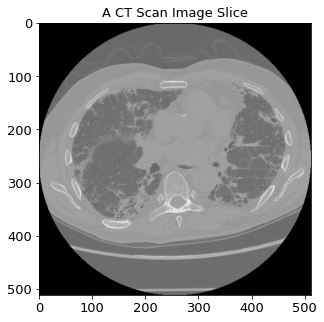

In [4]:
# Select a sample slice to work with
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('A CT Scan Image Slice')
plt.imshow(im, cmap='gray')
print('Image Dimensions:', im.shape)

## Preprocessing the CT Image

In [5]:
# TODO: Implement histogram plotting
def imgKMeans(img, K, showOutput=0, showHistogram=0):
    '''
    Apply KMeans on an image with the number of clusters K
    Input: Image, Number of clusters K
    Output: Dictionary of cluster center labels and points, Output segmented image
    '''
    imgflat = np.reshape(img, img.shape[0] * img.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(n_clusters=K, verbose=0)
    
    kmmodel = kmeans.fit(imgflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    center_labels = dict(zip(np.arange(K), centers))
    
    output = np.array([center_labels[label] for label in labels])
    output = output.reshape(img.shape[0], img.shape[1]).astype(int)
    
    print(len(labels), 'Labels: \n', labels)
    print(len(centers), 'Centers: \n', centers)
    print('Center labels and their points:', center_labels)
    
    if showOutput:

        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(output)
        axes[1].set_title('Image after KMeans (K = ' + str(K) + ')')
    
    return center_labels, output

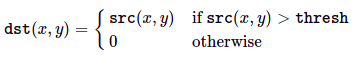

262144 Labels: 
 [0 0 0 ... 0 0 0]
3 Centers: 
 [[8.82521695e-02]
 [1.12269714e+02]
 [1.57879115e+02]]
Center labels and their points: {0: array([0.08825217]), 1: array([112.26971435]), 2: array([157.87911491])}


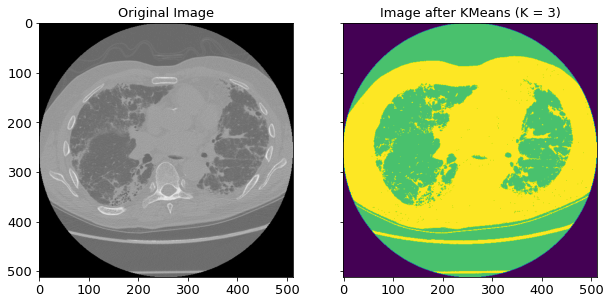

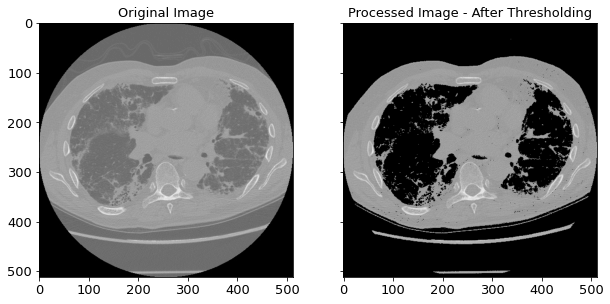

In [6]:
def preprocessImage(img, showOutput=0):
    '''
    Preprocess the image by applying truncated thresholding using KMeans
    Input: Image
    Output: Preprocessed image
    '''
    centroids, segmented_img = imgKMeans(im, 3, showOutput=1)
    
    sorted_center_values = sorted([i[0] for i in centroids.values()])
    threshold = (sorted_center_values[-1] + sorted_center_values[-2]) / 2
    
    retval, procImg = cv2.threshold(im, threshold, 255, cv2.THRESH_TOZERO) 
    
    if showOutput:
        
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(procImg, cmap='gray')
        axes[1].set_title('Processed Image - After Thresholding')
    
    return procImg

procImg = preprocessImage(im, showOutput=1)

## Convex Hull of Foreground Mask

In [7]:
def chullForegroundMask(img):
    '''
    Generate a convex hull of foreground mask
    Input: Whole chest CT image in grayscale format (512x512)
    Output: Convex hull of foreground mask in binary format (512x512)
    '''
    
    centroid_clusters, segmented_img = imgKMeans(img, 2, showOutput=1)
    
    fg_threshold = sum(centroid_clusters.values())[0] / 2
    
    retval, fg_mask = cv2.threshold(img, fg_threshold, 255, cv2.THRESH_BINARY) 
    
    fg_mask_opened = opening(fg_mask, square(3))
    fg_mask_opened2 = opening(fg_mask_opened, disk(4))
    
    fg_mask = fg_mask_opened2
    
    ch_fg_mask = convex_hull_image(fg_mask)
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 10))
    axes = axes.ravel()
    
    axes[0].set_title('Foreground Mask - Opening (Square SE)')
    axes[0].imshow(fg_mask_opened, cmap='gray')
    
    axes[1].set_title('Foreground Mask - Opening (Square+Disk SEs)')
    axes[1].imshow(fg_mask_opened2, cmap='gray')
    
    axes[2].set_title('Convex Hull of Foreground Mask')
    axes[2].imshow(ch_fg_mask, cmap='gray')
    
    return fg_mask, ch_fg_mask, fg_threshold

262144 Labels: 
 [0 0 0 ... 0 0 0]
2 Centers: 
 [[  0.        ]
 [157.87911491]]
Center labels and their points: {0: array([0.]), 1: array([157.87911491])}
Threshold: 78.939557454822


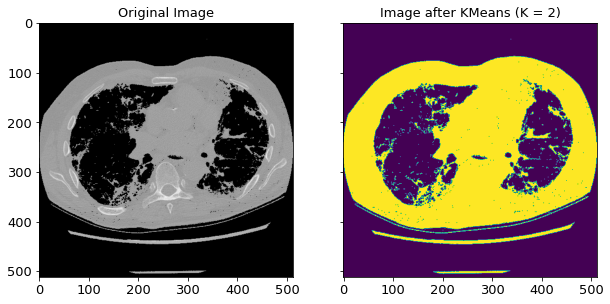

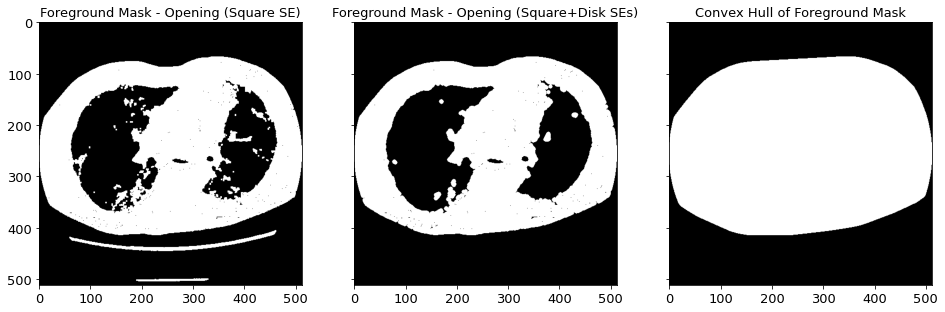

In [8]:
fg_mask, ch_fg_mask, fg_threshold = chullForegroundMask(procImg)
print('Threshold:', fg_threshold)

## Convex Hull of Lung Mask

In [85]:
def chullLungMask(img, ch_fg_mask, fg_threshold):
    '''
    Generate a convex hull of lung mask
    Input: Whole chest CT image in grayscale format (512x512),
           Convex hull of foreground mask in binary format (512x512)
    Output: Convex hull of lung mask in binary format (512x512),
            Intermediate heart mask in binary format (512x512)
    '''
    
    enhanced = img.copy()
    lung_mask = np.zeros(img.shape).astype(int)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if ch_fg_mask[i][j] == 0:
                enhanced[i][j] = 255
         
    retval, lung_mask = cv2.threshold(enhanced, fg_threshold, 255, cv2.THRESH_BINARY_INV) 
    
    lung_mask_op1 = opening(lung_mask, square(2))
    lung_mask_op1cl1 = closing(lung_mask_op1, disk(8))    
    lung_mask_op2cl1 = opening(lung_mask_op1cl1, square(8))
    lung_mask_op3cl1 = opening(lung_mask_op2cl1, disk(8))
    lung_mask_op3cl2 = closing(lung_mask_op3cl1, disk(16))

    ch_lung_mask = convex_hull_image(lung_mask_op3cl2)
    
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 16))
    axes = axes.ravel()
    
    axes[0].set_title('Original Image')
    axes[0].imshow(img, cmap='gray')
    
    axes[1].set_title('Enhanced Image')
    axes[1].imshow(enhanced, cmap='gray')
    
    axes[2].set_title('Lung Mask')
    axes[2].imshow(lung_mask, cmap='gray')
    
    axes[3].set_title('On Opening with Square SE (2)')
    axes[3].imshow(lung_mask_op1, cmap='gray')
    
    axes[4].set_title('On Closing with Disk SE (8)')
    axes[4].imshow(lung_mask_op1cl1, cmap='gray')
    
    axes[5].set_title('On Opening with Square SE (8)')
    axes[5].imshow(lung_mask_op2cl1, cmap='gray')
    
    axes[6].set_title('On Opening with Disk SE (8)')
    axes[6].imshow(lung_mask_op3cl1, cmap='gray')
    
    axes[7].set_title('On Closing with Disk SE (16)')
    axes[7].imshow(lung_mask_op3cl2, cmap='gray')
    
    axes[8].set_title('Convex Hull of Lung Mask')
    axes[8].imshow(ch_lung_mask, cmap='gray')
    
    return enhanced

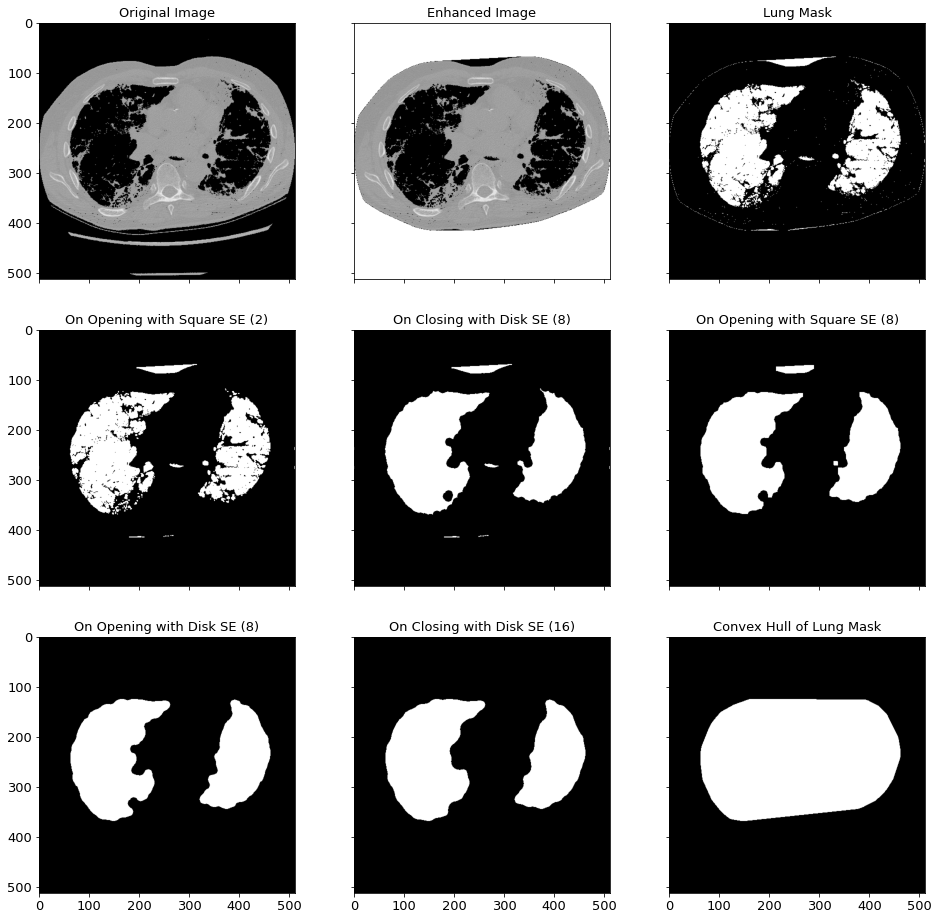

In [86]:
enhanced = chullLungMask(procImg, ch_fg_mask, fg_threshold)

In [11]:
def chullLungMaskWithConnComp(img, fg_mask):
    '''
    Generate a convex hull of lung mask
    Input: Whole chest CT image in grayscale format (512x512),
           Convex hull of foreground mask in binary format (512x512)
    Output: Convex hull of lung mask in binary format (512x512),
            Intermediate heart mask in binary format (512x512)
    '''
    inv_fg_mask = 255 - fg_mask
    
    labeled_image, count = label(inv_fg_mask,connectivity=2, return_num=True)
        
    print(labeled_image)
    print(count)
    
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
    axes = axes.ravel()
    
    axes[0].set_title('Original Image')
    axes[0].imshow(inv_fg_mask, cmap='gray')
    
    axes[1].set_title('Connected Components')
    axes[1].imshow(labeled_image)
    
#     axes[2].set_title('Lung Mask')
#     axes[2].imshow(lung_mask, cmap='gray')
    
#     axes[3].set_title('Lung Mask - Opening (Square SE)')
#     axes[3].imshow(lung_mask_opened, cmap='gray')
    
#     axes[4].set_title('Lung Mask - Opening (Square+Disk SEs)')
#     axes[4].imshow(lung_mask_opened2, cmap='gray')
    
#     axes[5].set_title('Convex Hull of Lung Mask')
#     axes[5].imshow(lung_mask_closed2, cmap='gray')
    
    return labeled_image, count

[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [54 54 54 ... 54 54 54]
 [54 54 54 ... 54 54 54]
 [54 54 54 ... 54 54 54]]
137


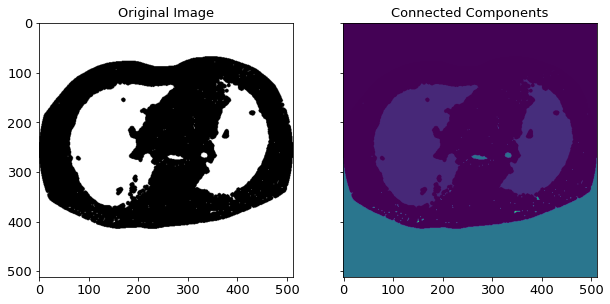

In [12]:
labeled_image, count = chullLungMaskWithConnComp(procImg, fg_mask)

In [13]:
# compute object features and extract object areas
object_features = regionprops(labeled_image)
object_areas = sorted([objf["area"] for objf in object_features])

In [14]:
object_areas = sorted(np.array([objf["area"] for objf in object_features]))[-1]

(240, 512)


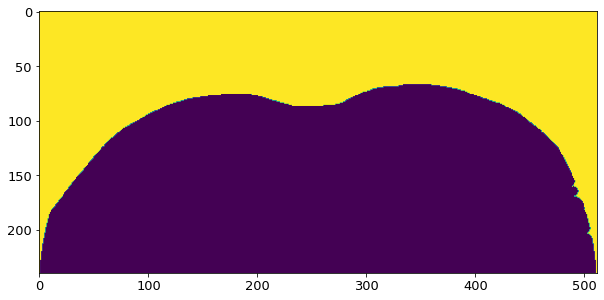

In [15]:
a = object_features[0].image
print(a.shape)
plt.imshow(a)